##  Optimising image augmentations across an entire image data-set using a custom tensorflow pipeline

### Author/ML Engineer: Leon Hamnett - [linkedIn](https://www.linkedin.com/in/leon-hamnett/)


### Introduction:

As part of a team of machine learning engineers, I took part in a [datadriven contest](https://https-deeplearning-ai.github.io/data-centric-comp/) organised by Andrew Ng (a well known machine learning teacher and researcher). The aim of this competition was to focus on methods to improve dataset quality as opposed to improving the machine learning model itself. 

During this contest we created a number of different image datasets using such methods as cleaning and relabelling the existing dataset, creating synthetic data and applying a number of different image transforms and augmentations on the images. 

During dataset augmentation within computer vision, it is necessary to augment the existing dataset using things like rotations or flipping of images to generate a more robust dataset and train the model to a higher quality.

This notebook was used to apply image augmentations and transformations to an entire image dataset as efficiently as possible. To do this we build a pipeline using the tensorflow library which performs the following functions:

1. Read in a list of filenames, and then 
2. Using parallel processing and optimised code, read and load the images from the filenames
3. Turn images into arrays of pixel values
4. Apply a set of transformations, augmentations and image resizing operations across the entire image dataset using tensors
4. Convert the set of transformed images from tensor format, back into pixel values and then save the augmented dataset.

### Importing libaries:

During this notebook, we use some of the lower level tensorflow functions to construct our input and output pipelines, and also we use a number of computer vision packages like cv2 as well as a package called albumentations, specifcially designed for image augmentations. We also use file and folder manipulation packages like os and shutil to copy and move our data around. 

In [ ]:
import tensorflow as tf
from tensorflow import keras
AUTOTUNE = tf.data.experimental.AUTOTUNE
%load_ext tensorboard
from tensorboard.plugins.hparams import api as hp
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
!pip install git+https://github.com/albumentations-team/albumentations
import albumentations as A

import json
import sys
import os
from os import getcwd
import shutil
import numpy as np
import random
#!pip install -U keras-tuner
#import keras_tuner as kt

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-6yj8pr5o
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-6yj8pr5o


In [ ]:
#mount google drive to access files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Setting up the folder structure:

In [ ]:
print(os.getcwd()) # check current working directory
os.chdir('/content/drive/MyDrive/Datadriven_contest/Training') #set working directory
print(os.getcwd())
images = '/content/drive/MyDrive/Datadriven_contest/Image_datasets'
print(os.listdir(images)) #check image folders to choose from
#change image_dir below to correctly refer to folder with train_valid images
image_dir = "/content/drive/MyDrive/Datadriven_contest/Image_datasets"
train_dir = os.path.join(image_dir,'to_process/train')


/content
/content/drive/MyDrive/Datadriven_contest/Training
['baseline.zip', 'image_gen.zip', 'current_train', 'combined', 'baseline', 'image_gen', 'image_gen_base.zip', '.ipynb_checkpoints', 'image_generated_and_baseline', 'baseline_and_aug_zoom_flip', 'augmented_zoom_flip', 'augmented_blur', 'augmented_thresh', 'image_gen2_with_curls.zip', 'image_gen2_curls_aug_transl', 'baseline_imagegen2_aug_zoom_flip_thresh_blur', 'baseline_imagegen2_aug_zoom_flip_thresh_blur.zip', 'baseline_imagegen2', 'image_gen3_no_aug.zip', 'image_gen3_no_aug', 'baseline_test_upsampled', 'baseline_test_upsampled_flip', 'image_gen4_no_aug_smaller.zip', 'image_gen4_no_aug', 'image_gen4_baseline_test_upsampled', 'processed_images_01', 'processed_images_01_train_val', 'Create_shuffle train val split for train.ipynb', 'processed_images_01_train_val.zip', 'processed_images_02', 'processed_images_02_train_val', 'augmented_shift_rotate.zip', 'to_process', 'Final -Create shuffle train val split for train (>10,000 image

### Define the function to apply the transformations:

We define a function that takes as input a folder path with the images to be transformed, a function cointaining a series of transformations to apply, as well a batch size for the output of the tensor containing the transformed images. 

The function has the following sub functions:
1. get_files_labels - generates a list of file paths and associated class labels
2. parse_image - uses parallel processing to read in the filenames, use the filename to load in the images, turn the images into an array of numbers, then apply the image augmentations and transformations.
3. tf_parse_image - wrapper function for the above function. As we are applying python/numpy transformations to a set of tensors, we need to wrap the parse image function so it works with the tensorflow framework.
4. configure_for_performance - this function shuffles, batches and prefetches the dataset to ensure the new dataset with the transformed images can be created as quickly as possible. 

In [ ]:
#better for efficiency , can include augmentation function
#this function will take a folder path as input, as well as a transformation function or functions (currently using: https://albumentations.ai/docs/) , and batch size.
#it can then create datasets of transfortmed images and associated labels, either combined into a single dataset with tf.zip or as two separate datasets of images and labels.
def make_dataset(path, transform_f, batch_size):
  numerals = ["i", "ii", "iii", "iv", "v", "vi", "vii", "viii", "ix", "x"] #class labels
  #get filepaths and labels
  def get_files_labels(input_dir):
    image_paths = [] #empty list to store filepaths
    labels = [] # empty list to store image labels
    labels_zero = [0]*10 # initialise array of zeros, so we can use this to apply one-hot encoding to the image labels

    for root, dirnames, filenames in os.walk(input_dir): #look at all folders and subfolders and get the filenames
        for filename in filenames: #loop through filenames
            temp_path = os.path.join(root,filename) # temp filepath
            image_paths.append(temp_path) # add to image paths list
            int_label = numerals.index(temp_path.split('/')[-2]) # split filename path to get integer value for label 
            temp_label = labels_zero.copy()
            temp_label[int_label] = 1 #one-hot encode the label
            labels.append(temp_label) # add label to label list
    return image_paths, labels 

  filenames,labels = get_files_labels(path) #make filenames and labels
  print('got filenames and labels from dir')

  #load image and apply augmentations
  def parse_image(filename):
    image = tf.io.read_file(filename) #read filename
    image = tf.io.decode_png(image, channels=0) #convert from png greyscale
    np_image = image.numpy()[:,:,0]  #convert to np array , drop channel dim as color dim not needed

    if transform_f == None: # if no transform is given, no image transforation is needed
      aug_image = np_image
    else:
      aug_image = transform_f(image=np_image)["image"] #apply transformations/augmentations on image

    aug_image = tf.cast(aug_image, tf.float32) #convert type to match with wrapper function
    return aug_image

  #wrap parse image function as tensorflow function
  def tf_parse_image(input):
    y = tf.numpy_function(parse_image, [input],tf.float32) 
    return y 

  def configure_for_performance(ds): #takes tensor dataset as input and optimises for repeated calls 
    ds = ds.shuffle(buffer_size=10000)
    ds = ds.batch(batch_size)
    ds = ds.repeat()
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

  
  filenames_ds = tf.data.Dataset.from_tensor_slices(filenames) #make dataset of filenames
  print('file names parsed')
  images_ds = filenames_ds.map(lambda x: tf_parse_image(x), num_parallel_calls=tf.data.experimental.AUTOTUNE) #maps parse image function to filenames dataset to create images
  labels_ds = tf.data.Dataset.from_tensor_slices(labels) #make ds of labels

  print('made image and label ds')
  ds_out = tf.data.Dataset.zip((images_ds, labels_ds)) #combine each transformed image with its associated label and make into new dataset
  print('merged image and label ds')
  
  ds_out = configure_for_performance(ds_out) # shuffle, batch, prefetch
  print('done')
  return ds_out 

# we configure a basic transform to make sure the pipeline is working correctly
transform = A.Compose([
    A.Rotate (limit=90, interpolation=1, always_apply=False, p=0.0),
    A.Resize(64,64)
])

ds_out = make_dataset(train_dir,transform,512)

got filenames and labels from dir
file names parsed
made image and label ds
merged image and label ds
done


### Apply the transformation function/pipeline to the image dataset

Now that we see the function is working correctly, we define a pipeline of transforms and augementations to apply to the image dataset.

We resize all input images to a uniform size, we apply a number of transformations/augmentations in order (sometimes choosing randomly between a number of different option) and then output a modified image dataset.

got filenames and labels from dir
file names parsed
made image and label ds
merged image and label ds
done
label  tf.Tensor([0 1 0 0 0 0 0 0 0 0], shape=(10,), dtype=int32)


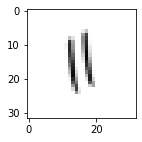

label  tf.Tensor([0 0 0 0 0 0 1 0 0 0], shape=(10,), dtype=int32)


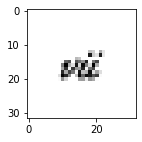

label  tf.Tensor([0 0 0 1 0 0 0 0 0 0], shape=(10,), dtype=int32)


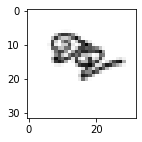

label  tf.Tensor([0 0 0 0 0 0 1 0 0 0], shape=(10,), dtype=int32)


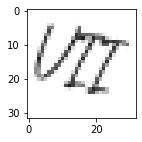

label  tf.Tensor([0 0 0 0 0 0 0 0 0 1], shape=(10,), dtype=int32)


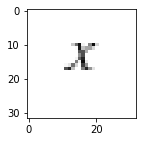

label  tf.Tensor([0 0 0 0 0 1 0 0 0 0], shape=(10,), dtype=int32)


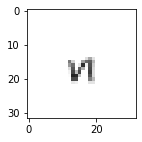

label  tf.Tensor([0 1 0 0 0 0 0 0 0 0], shape=(10,), dtype=int32)


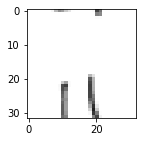

label  tf.Tensor([0 0 1 0 0 0 0 0 0 0], shape=(10,), dtype=int32)


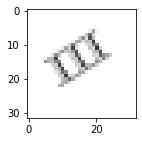

label  tf.Tensor([0 0 0 0 0 1 0 0 0 0], shape=(10,), dtype=int32)


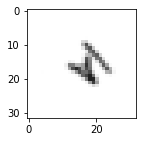

label  tf.Tensor([0 0 0 0 0 1 0 0 0 0], shape=(10,), dtype=int32)


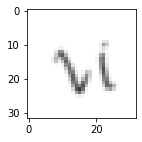

label  tf.Tensor([0 0 0 0 0 0 1 0 0 0], shape=(10,), dtype=int32)


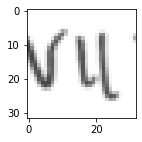

label  tf.Tensor([0 1 0 0 0 0 0 0 0 0], shape=(10,), dtype=int32)


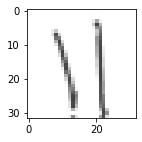

label  tf.Tensor([0 0 1 0 0 0 0 0 0 0], shape=(10,), dtype=int32)


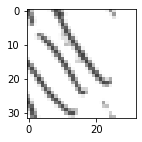

label  tf.Tensor([0 0 0 0 0 0 1 0 0 0], shape=(10,), dtype=int32)


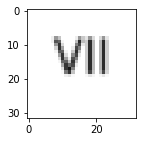

label  tf.Tensor([0 0 0 0 0 0 1 0 0 0], shape=(10,), dtype=int32)


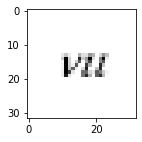

label  tf.Tensor([0 0 0 0 0 1 0 0 0 0], shape=(10,), dtype=int32)


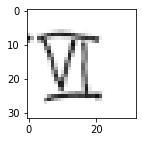

label  tf.Tensor([0 0 1 0 0 0 0 0 0 0], shape=(10,), dtype=int32)


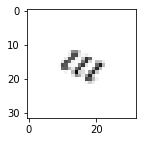

label  tf.Tensor([0 0 0 0 0 0 0 1 0 0], shape=(10,), dtype=int32)


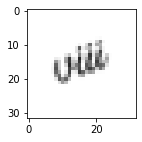

label  tf.Tensor([0 0 0 1 0 0 0 0 0 0], shape=(10,), dtype=int32)


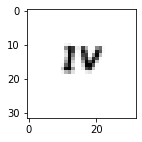

label  tf.Tensor([0 0 0 1 0 0 0 0 0 0], shape=(10,), dtype=int32)


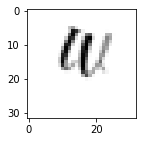

label  tf.Tensor([0 0 1 0 0 0 0 0 0 0], shape=(10,), dtype=int32)


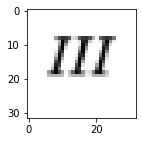

label  tf.Tensor([0 0 0 0 0 0 0 0 0 1], shape=(10,), dtype=int32)


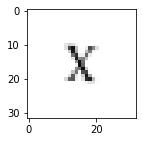

label  tf.Tensor([0 0 0 0 0 0 0 1 0 0], shape=(10,), dtype=int32)


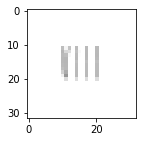

label  tf.Tensor([0 0 0 0 0 0 0 1 0 0], shape=(10,), dtype=int32)


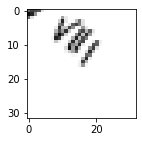

label  tf.Tensor([0 0 0 0 0 0 0 0 1 0], shape=(10,), dtype=int32)


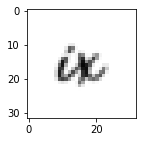

label  tf.Tensor([0 0 1 0 0 0 0 0 0 0], shape=(10,), dtype=int32)


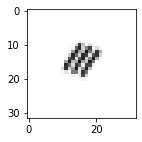

label  tf.Tensor([0 0 0 0 0 0 0 1 0 0], shape=(10,), dtype=int32)


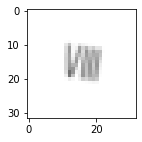

label  tf.Tensor([0 0 0 0 0 0 0 0 1 0], shape=(10,), dtype=int32)


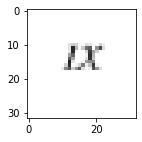

label  tf.Tensor([0 1 0 0 0 0 0 0 0 0], shape=(10,), dtype=int32)


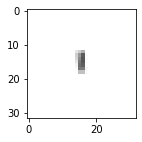

label  tf.Tensor([0 0 0 0 0 0 0 0 0 1], shape=(10,), dtype=int32)


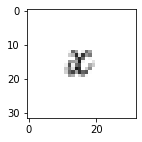

label  tf.Tensor([0 0 0 0 0 0 0 1 0 0], shape=(10,), dtype=int32)


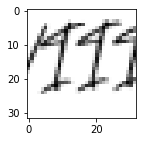

label  tf.Tensor([0 0 0 1 0 0 0 0 0 0], shape=(10,), dtype=int32)


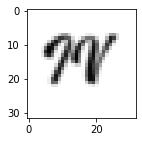

label  tf.Tensor([0 0 0 0 0 1 0 0 0 0], shape=(10,), dtype=int32)


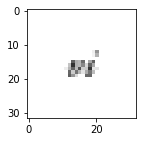

label  tf.Tensor([0 0 0 0 0 0 0 0 1 0], shape=(10,), dtype=int32)


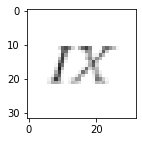

label  tf.Tensor([0 0 0 0 0 0 1 0 0 0], shape=(10,), dtype=int32)


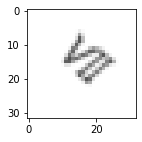

label  tf.Tensor([1 0 0 0 0 0 0 0 0 0], shape=(10,), dtype=int32)


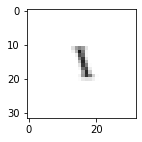

label  tf.Tensor([0 0 0 0 0 0 0 1 0 0], shape=(10,), dtype=int32)


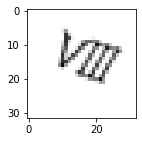

label  tf.Tensor([0 0 0 0 1 0 0 0 0 0], shape=(10,), dtype=int32)


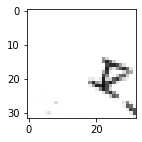

label  tf.Tensor([0 0 0 0 0 0 0 0 0 1], shape=(10,), dtype=int32)


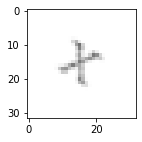

label  tf.Tensor([0 0 0 0 0 0 0 0 0 1], shape=(10,), dtype=int32)


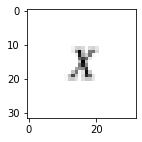

label  tf.Tensor([0 0 0 0 0 0 0 0 0 1], shape=(10,), dtype=int32)


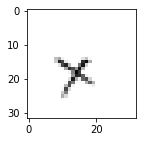

label  tf.Tensor([0 0 0 1 0 0 0 0 0 0], shape=(10,), dtype=int32)


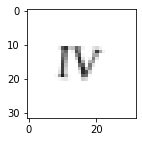

label  tf.Tensor([0 0 0 0 0 0 0 0 1 0], shape=(10,), dtype=int32)


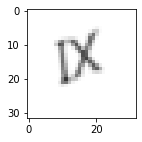

label  tf.Tensor([0 0 0 1 0 0 0 0 0 0], shape=(10,), dtype=int32)


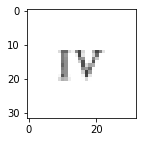

label  tf.Tensor([0 0 0 0 1 0 0 0 0 0], shape=(10,), dtype=int32)


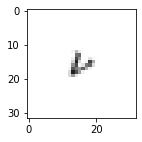

label  tf.Tensor([0 0 0 0 0 0 1 0 0 0], shape=(10,), dtype=int32)


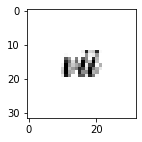

label  tf.Tensor([0 0 0 0 0 0 1 0 0 0], shape=(10,), dtype=int32)


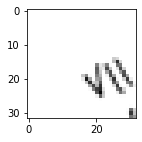

label  tf.Tensor([0 0 1 0 0 0 0 0 0 0], shape=(10,), dtype=int32)


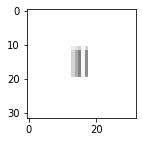

label  tf.Tensor([0 0 0 0 0 0 0 0 1 0], shape=(10,), dtype=int32)


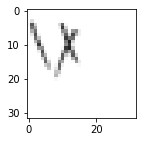

label  tf.Tensor([0 1 0 0 0 0 0 0 0 0], shape=(10,), dtype=int32)


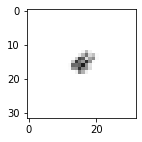

In [ ]:
#define transformations and apply to entire dataset

#individual image transformations to be applied
pix_size_during = 64
TRANS = A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0, rotate_limit=0,p=0.5)
R = A.Rotate (limit=40, interpolation=1, always_apply=False, p=0.5)
ZOOM = A.ShiftScaleRotate(shift_limit=0, scale_limit=0.15, rotate_limit=0,p=0.5)
BLUR = A.GaussianBlur(blur_limit=(1, 3), sigma_limit=0, always_apply=False, p=0.4)
SHARP_1 = A.Sharpen(alpha=(0.9, 1.0), lightness=(0.5, 1.0), always_apply=False, p=0.5) #alpha is sharpness value, lightness is opacity 
NOISE = A.GaussNoise(var_limit=(10.0, 40.0), mean=0, per_channel=False, always_apply=False, p=0.4)
CROP = A.RandomSizedCrop ([46,46], pix_size_during, pix_size_during, w2h_ratio=1.0, interpolation=1, always_apply=False, p=0.4)
COARSE_DROP = A.CoarseDropout(max_holes=1, max_height=20, max_width=20, min_holes=1, min_height=5, min_width=15,fill_value=120,always_apply=False, p=0.4)
RESIZE_1 = A.Resize(pix_size_during, pix_size_during, interpolation=cv2.INTER_AREA, always_apply=True, p=1)
RESIZE_2 = A.Resize(32, 32, interpolation=cv2.INTER_AREA, always_apply=True, p=1)

# define transformation pipeline
transform = A.Compose([
    RESIZE_1,
    np.random.choice([ZOOM,TRANS]),
    R, 
    np.random.choice([BLUR,NOISE]),
    RESIZE_2   
])

# obtain transformed image dataset
trans_ds = make_dataset(train_dir,transform,512)

#check the outputted dataset to make sure transformations have been applied correctly and that the correct label is assocated with each image
for images,labels in trans_ds.unbatch().take(50):
  print('label ',labels)
  # print(images)
  # img = mpimg.imread(images)
  #new_image = images[:,:].map(contrast)
  plt.rcParams["figure.figsize"] = (2,2)
  plt.imshow(images[:,:],cmap='gray', vmin=0, vmax=255)
  plt.show()


We can see that the above function can apply transformations and augmentations to an image dataset of maybe 20,000 images in a few seconds. If we had not optimised this process, this could have taken 30 or 40 minutes so we can see we have achieved a considerable improvement in time and efficiency to pass the images through our pipeline, transform them, and then pass them out to be used as needed.

### Saving the modified images:

Now that we have used parallel processing to efficiently apply image transformations to an entire dataset, we can save our modified dataset.

In [ ]:
#save modified images
to_save_dir = os.path.join(image_dir,'temp_processed_images') #create new folder
if 'temp_processed_images' in os.listdir(image_dir):
  shutil.rmtree(to_save_dir) #delete folder is already exists

os.mkdir(to_save_dir) #create new folder
numerals = ["i", "ii", "iii", "iv", "v", "vi", "vii", "viii", "ix", "x"] #image classes/labels
for num in numerals: #loop through image classes and make new folders
  temp_path = os.path.join(to_save_dir,num)
  os.mkdir(temp_path)

x=0
for images,labels in trans_ds.take(50).unbatch(): #unbatch and unpack the modified images
  #get image label/class
  np_label = labels.numpy()
  label_index = np.where(np_label== 1)[0] # find the index in the array with a '1'
  numeral_label = numerals[int(label_index)] #index corresponds to which numeral this image is showing

  #encode image
  temp_image = images.numpy()
  # encoded_img = tf.io.encode_png(
  #   temp_image, compression=-1)
  
  #save image
  path_to_save = os.path.join(to_save_dir,numeral_label,str(x))+'.png' #create path and filename
  cv2.imwrite(path_to_save,temp_image) #save the image to the relevant folder

  if x % 100 == 0: #progress bar
    print(x,' images saved')
  else:
    pass

  if x >= 30000: #stop if images are more than this amount, due to continual prefetching of images this loop will run forever unless terminated
    break
  x+=1

print('images saved')

Now we have applied the augmentations to our image dataset and we have saved the images ready to submit for the competition entry. 